In [122]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from analysis import *
from getters import * 
from plotters import * 
from models.model_config import *

views=[0]
models=["gcn_student_ensamble_3"]
CV=["3Fold", "5Fold", "10Fold"]
run=0
dataset = "gender_data"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
view_data_mean_1, _ = view_reproducibility_analysis(dataset, models, CV, views, run, students=[0], model_args=[gcn_student_ensamble_3_args_0_4])
view_data_mean_2, _ = view_reproducibility_analysis(dataset, models, CV, views, run, students=[1], model_args=[gcn_student_ensamble_3_args_0_4])
view_data_mean_3, _ = view_reproducibility_analysis(dataset, models, CV, views, run, students=[2], model_args=[gcn_student_ensamble_3_args_0_4])

In [5]:
view_data_mean_1, view_data_mean_2, view_data_mean_3

(array([[0.87777778, 0.87777778]]),
 array([[1., 1.]]),
 array([[0.96666667, 0.96666667]]))

In [124]:
def get_mean_CV_metric_student_model(dataset, model, analysis_type, training_type, view, run, student, dataset_split, model_args):

    import sklearn.metrics as metrics

    #get the mean metric for a student for a particular CV training_type 
    
    student_acc, student_recall, student_precision, student_f1 = 0, 0, 0, 0
    acc_mean, recall_mean, precision_mean, f1_mean = [], [], [], []
    
    if training_type == "3Fold":
        cv_number = 3
    if training_type == "5Fold":
        cv_number = 5
    if training_type == "10Fold":
        cv_number = 10  
    
    for i in range(cv_number):
        x = get_labels_and_preds(dataset=dataset, 
                                model=model,
                                analysis_type=analysis_type, 
                                training_type=training_type,  
                                cv_n=i, 
                                view=view, 
                                run=run, 
                                dataset_split=dataset_split, 
                                student=student, 
                                model_args=model_args)
        result = {
            'prec': metrics.precision_score(x['labels'],  x['preds']),
            'recall': metrics.recall_score(x['labels'],  x['preds']),
            'acc': metrics.accuracy_score(x['labels'],  x['preds']),
            'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
        recall_mean.append(result['recall'])
        precision_mean.append(result['prec'])
        f1_mean.append(result['F1'])
    
    student_acc = np.mean(acc_mean)
    student_recall = np.mean(recall_mean)
    student_precision = np.mean(precision_mean)
    student_f1 = np.mean(f1_mean)

    return student_acc, student_f1, student_recall, student_precision

In [125]:
def get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    """
    USAGE:
    runs = [i for i in range(10)]
    CV=["3Fold", "5Fold", "10Fold"]
    model = "gcn_student_ensamble_3"
    analysis_type="model_assessment"
    model_args= gcn_student_ensamble_args
    dataset_split="val"
    view=2

    get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    """

    all_student_metrics_mean = []
    all_student_metrics_var = []

    for student in range(model_args["n_students"]):

        model_metrics_runs = []
        
        for run in runs:
                
            model_metrics = []
            
            for training_type in CV:
                
                model_metrics.append(get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                )
                )
            
            model_metrics = np.mean(model_metrics, axis=0)
            model_metrics_runs.append(model_metrics)
        all_student_metrics_var.append(np.var(model_metrics_runs, axis=0))
        all_student_metrics_mean.append(np.mean(model_metrics_runs, axis=0))

    return all_student_metrics_mean, all_student_metrics_var


In [126]:
def get_best_student_ensamble(model, view, CV, runs, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, _ = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return [best_rep_max, student_var[student_max], student_max], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]
    

# FIND THE BEST STUDENT IN ENSAMBLE 

In [95]:
analysis_type="model_assessment"
dataset_split="val"

for view in [0,2,4,5]:
    print(get_best_student_ensamble(
        model="gcn_student_ensamble_3", 
        view=view, 
        CV=CV,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=gcn_student_ensamble_3_args_0_4
    ))

([0.96875, 1.8229166666666675e-05, 2], [0.96875, 1.8229166666666675e-05, 2], [0.96875, 1.8229166666666675e-05, 2])
([0.9320833333333335, 0.0008103587962962955, 0], [0.9320833333333335, 0.0008103587962962955, 0], [0.8823611111111112, 0.00030904706790123553, 1])
([0.9577777777777776, 0.00010655864197530909, 2], [0.9577777777777776, 0.00010655864197530909, 2], [0.9577777777777776, 0.00010655864197530909, 2])
([0.9486111111111111, 0.0003387345679012343, 0], [0.9126388888888888, 0.0003250192901234564, 1], [0.9126388888888888, 0.0003250192901234564, 1])


## Overview of the models and ensamble 

In [127]:
def get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    #EACH FOLD INDIVIDUAL

    student_data_mean = [] 
    student_data_var = [] 
    
    for student in range(model_args["n_students"]):

        run_data = []   

        for run in runs:

            model_metrics = []
            
            for training_type in CV:

                model_cv_metrics = get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                    )
                model_metrics.append(model_cv_metrics)
            
            run_data.append(model_metrics)
        
        student_data_mean.append(np.mean(run_data, axis=0))   
        student_data_var.append(np.std(run_data, axis=0))        

    return student_data_mean, student_data_var

In [128]:
def get_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average metrics across all runs and all cv for any model 
    #EACH FOLD INDIVIDUAL

    data_mean = [] 
    data_var = [] 

    run_data = []   


    for run in runs:

        model_metrics = []
        
        for training_type in CV:
            
            model_cv_metrics = get_mean_CV_metric_student_model(
                dataset=dataset, 
                model=model, 
                analysis_type=analysis_type, 
                training_type=training_type, 
                view=view, 
                run=run, 
                student=-1, 
                dataset_split=dataset_split,
                model_args=model_args
                )
            model_metrics.append(model_cv_metrics)
        
        run_data.append(model_metrics)
        
    data_mean.append(np.mean(run_data, axis=0))   
    data_var.append(np.std(run_data, axis=0))        

    return data_mean, data_var

In [46]:
views=[0, 2, 4, 5]

gcn_args = {
    "num_epochs":50, 
    "lr": 0.0001,
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn",
    "layers":2,
    "evaluation_method": "model_assessment" # model selection or model assessment
}

gcn_student_args = {
    "num_epochs":50, 
    "lr": 0.0001, 
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn_student",
    "evaluation_method": "model_assessment", # model selection or model assessment
    "alpha_ce": 1, 
    "T": 3, 
    "alpha_soft_ce": 2,
    "alpha_weight": 0
}
#models=["gcn", "gcn_student", "gcn_student_teacher"]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_ensamble_3"
runs = [i for i in range(9)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc", "f1", "recall", "precision"]
model_args= gcn_student_ensamble_3_args_0_4
for view in views:

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args) 
    mean_gcn, std_gcn = get_model_metric(dataset=dataset, model="gcn", CV=CV, runs=runs, analysis_type=analysis_type, dataset_split=dataset_split, view=view, model_args=gcn_args)
    mean_gcn_student, std_gcn_student = get_model_metric(dataset=dataset, model="gcn_student", CV=CV, runs=runs, analysis_type=analysis_type, dataset_split=dataset_split, view=view, model_args=gcn_student_args)
    mean_gcn_ts, std_gcn_ts = get_model_metric(dataset=dataset, model="gcn_student_teacher", CV=CV, runs=runs, analysis_type=analysis_type, dataset_split=dataset_split, view=view, model_args=gcn_student_args)
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = pd.DataFrame(np.array(mean)[:,:,i], columns=CV, index=["Student 1", "Student 2", "Student 3"]).round(3)
        std_df = pd.DataFrame(np.array(std)[:,:,i], columns=CV, index=["Student 1", "Student 2", "Student 3"]).round(3)
        
        mean_gcn_df = pd.DataFrame(np.array(mean_gcn)[:,:,i], columns=CV, index=["GCN"]).round(3)
        std_gcn_df = pd.DataFrame(np.array(std_gcn)[:,:,i], columns=CV, index=["GCN"]).round(3)

        mean_gcn_student_df = pd.DataFrame(np.array(mean_gcn_student)[:,:,i], columns=CV, index=["GCN Student"]).round(3)
        std_gcn_student_df = pd.DataFrame(np.array(std_gcn_student)[:,:,i], columns=CV, index=["GCN Student"]).round(3)

        mean_gcn_ts_df = pd.DataFrame(np.array(mean_gcn_ts)[:,:,i], columns=CV, index=["Vanilla KD"]).round(3)
        std_gcn_ts_df = pd.DataFrame(np.array(std_gcn_ts)[:,:,i], columns=CV, index=["Vanilla KD"]).round(3)
        
        final_mean_df = pd.concat([mean_gcn_df, mean_gcn_student_df, mean_gcn_ts_df, mean_df])
        final_var_df = pd.concat([std_gcn_df, std_gcn_student_df, std_gcn_ts_df, std_df])

        print(final_mean_df.astype(str) + u"\u00B1" + final_var_df.astype(str))

KeyError: 'backbone'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 0 Metric: acc


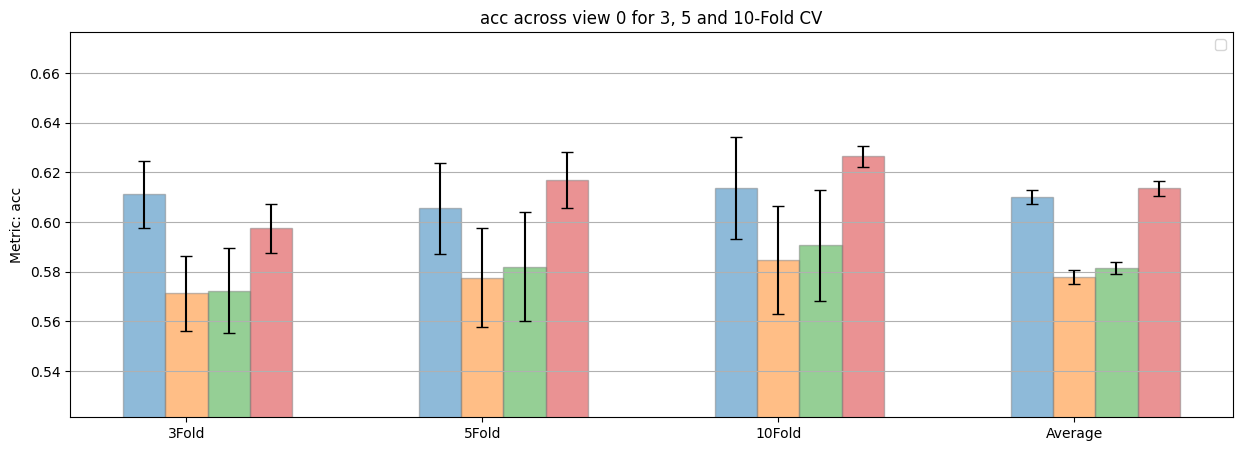

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 2 Metric: acc


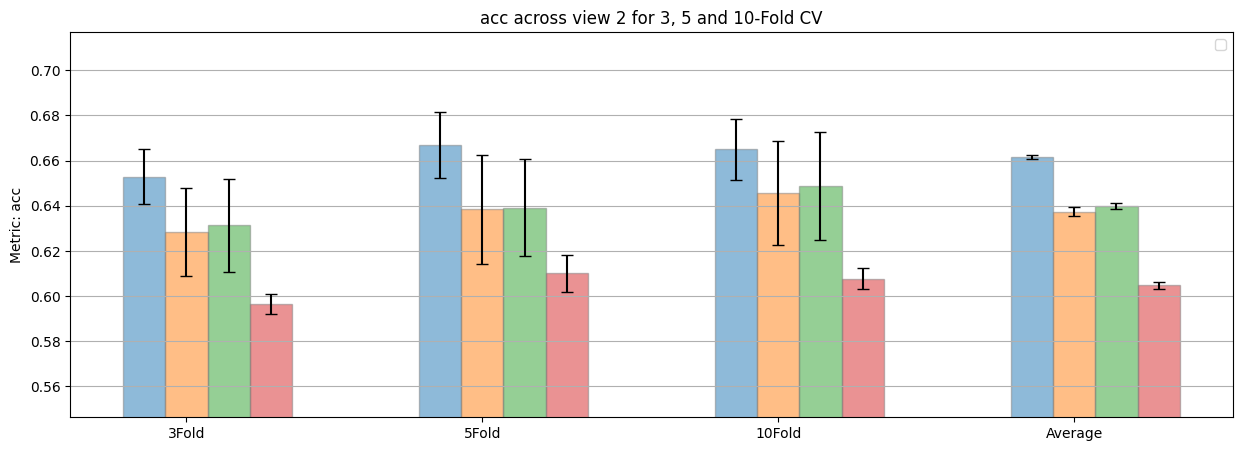

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 4 Metric: acc


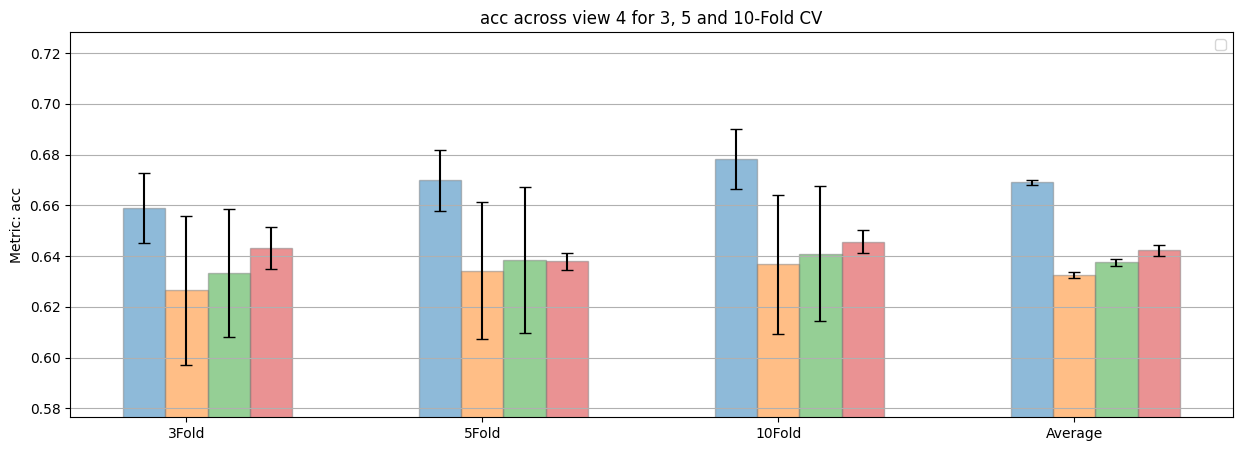

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 5 Metric: acc


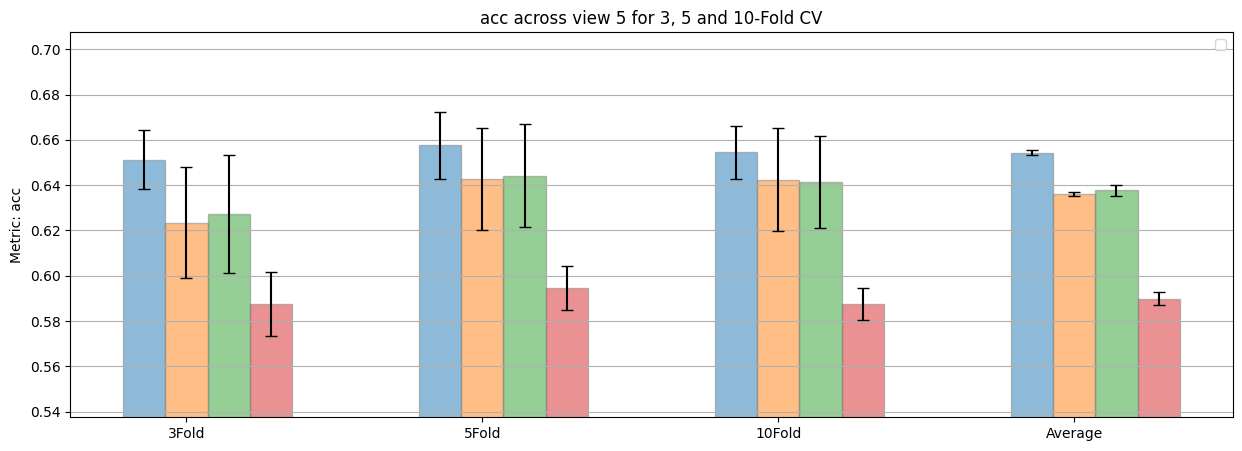

<Figure size 1500x500 with 0 Axes>

In [69]:
from models.model_config import *
views=[0, 2, 4, 5]
#models=["gcn", "gcn_student", "gcn_student_teacher"]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_ensamble_3"
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= gcn_student_ensamble_3_args_0_4
best_student = [2,0,2,0]

for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, 
                                                 CV=CV, view=view, 
                                                 run=run, 
                                                 metric="acc", 
                                                 dataset=dataset, 
                                                 dataset_split=dataset_split, 
                                                 analysis_type=analysis_type,
                                                 model_args=[gcn_args, gcn_student_args, gcn_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    mean = mean[index_student]
    std = std[index_student]
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = np.array(mean)[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(std)[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        barWidth = 1/7
        
        #GET MEAN AND STD ACROSS MEAN OF RUNS

        mean_all_runs = np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)]     
        mean_all_std = np.c_[ final_var_df, np.std(final_var_df, axis=1)]  
        
        X = np.arange(len(CV)+1)
        sep = 0.00
        for j, view_d in enumerate(mean_all_runs):
            plt.bar(X + sep, view_d, yerr=mean_all_std[j], capsize=4, width = barWidth, edgecolor ='grey', alpha=0.5)
            sep += barWidth
        
        max_y_lim = np.amax(mean_all_runs) + 0.05
        min_y_lim = np.amin(mean_all_runs) - 0.05
        plt.ylim(min_y_lim, max_y_lim)
        
        #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
        title = f"{metric} across view {view} for 3, 5 and 10-Fold CV"
        
        plt.ylabel(f"Metric: {metric}")
        x_ticks = [i for i in CV]+ ["Average"]
        
        plt.xticks([r + barWidth for r in range(len(CV)+1)], x_ticks)
        plt.title(title)
        plt.grid(axis = 'y')
        plt.legend()
        plt.show()
        plt.clf()   

# REPRODUCIBILITY

In [129]:
def view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=[0], model_args=None):
    """
    Reproducibility analysis for a single run for specific students in ensamble 
    student length = number of views, it is the specific student for each view
    """

    view_data_mean = []
    view_data_std = []

    for i, view in enumerate(views):
        
        model_result_mean = []
        model_result_std = []

        for j, model in enumerate(models):
            rep_score, std = view_specific_rep(dataset=dataset, view=view, model=model, run=run, CV=CV, student=students[i], model_args=model_args[j])
            model_result_mean.append(rep_score)
            model_result_std.append(std)

        view_data_mean.append(model_result_mean)
        view_data_std.append(model_result_std)

    view_data_std.append(list(np.std(view_data_mean, axis=0)))
    view_data_std = np.array(view_data_std).T

    view_data_mean.append(list(np.mean(view_data_mean, axis=0)))

    view_data_mean = np.array(view_data_mean).T
    
    return view_data_mean, view_data_std 

In [130]:
def plot_bar_chart_reproducibility_mulitple_runs_student_specific(dataset, views, models, CV, runs, students=0, model_args=None, save_fig=False):
    """
    USAGE:
    plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "gcn_student_ensamble_3", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,0,2,0], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args,
        gcn_student_ensamble_args,
    ], 
    save_fig=False
    )
    """
    plt.rcParams["figure.figsize"] = (15,5)

    barWidth = 1/(len(models)+1)

    mean_all_runs = []
    views=[0, 2, 4, 5]
    runs=[i for i in range(10)]
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=students, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)
    
    X = np.arange(len(views)+1)

    sep = 0.00
    for i, view_d in enumerate(mean_all_runs):
        if models[i] == "gcn":
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label=models[i]+"_teacher", alpha=0.5)
        elif models[i] == "gcn_student_ensamble_3":
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label="best_student_ensemble", alpha=0.5)
        else:
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label=models[i], alpha=0.5)
        
        sep += barWidth

    max_y_lim = 1 if np.amax(mean_all_runs) + np.max(mean_all_std) > 1 else np.amax(mean_all_runs) + np.max(mean_all_std)
    min_y_lim = 0 if np.amin(mean_all_runs) - np.max(mean_all_std) - 0.01 < 0 else np.amin(mean_all_runs) - np.max(mean_all_std) - 0.01
    plt.ylim(min_y_lim, max_y_lim)

    title = f"Reproducibility Score for Dataset:{dataset} across {len(runs)} different seeds for best student"

    plt.ylabel("Reproducibility Score")
    x_ticks = ["View {}".format(i) for i in views]+ ["Average"]

    plt.xticks([r + barWidth for r in range(len(mean_all_runs[0]))], x_ticks)
    plt.title(title)
    plt.grid(axis = 'y')
    plt.legend()
    if save_fig:
        if not os.path.exists(SAVE_DIR_FIGS+"reproducibility/"):
            os.makedirs(SAVE_DIR_FIGS+"reproducibility/")
        
        plt.savefig(SAVE_DIR_FIGS+"reproducibility/"+title+".png", dpi=150)
        plt.clf()
    
    else:
        plt.show()
        plt.clf()  

In [85]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_ensamble_3", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,0,2,0], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_3_args_0_4,
    ], 
    save_fig=False)

KeyboardInterrupt: 

In [42]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_ensamble_3", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,1,2,1], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_3_args_0_4,
    ], 
    save_fig=False)

KeyError: 'backbone'

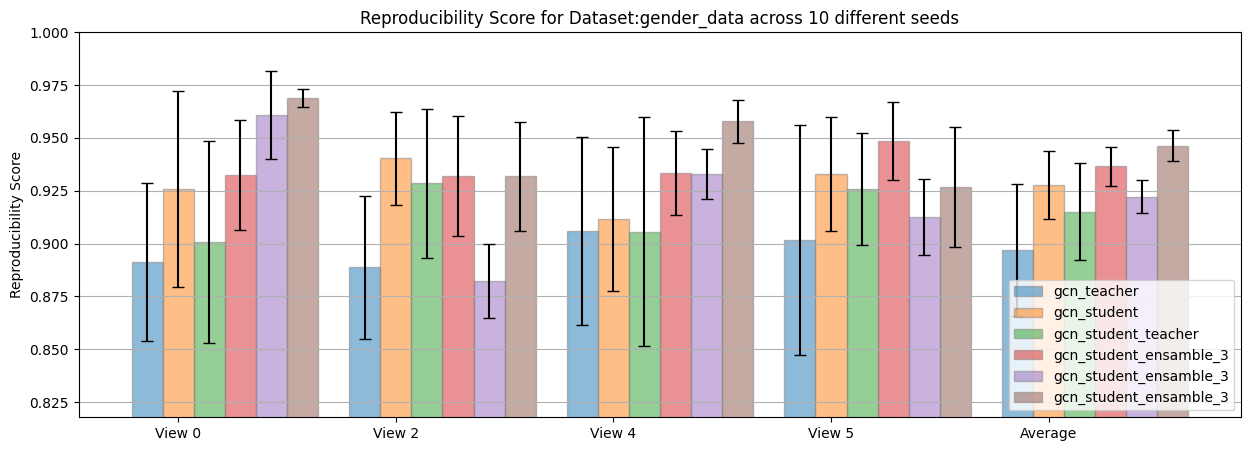

<Figure size 1500x500 with 0 Axes>

In [22]:
plot_bar_chart_reproducibility_mulitple_runs(dataset="gender_data", 
                                             views=[0, 2, 4, 5], 
                                             models=[  "gcn", 
                                                       "gcn_student",
                                                       "gcn_student_teacher",
                                                       "gcn_student_ensamble_3", 
                                                       "gcn_student_ensamble_3", 
                                                       "gcn_student_ensamble_3"
                                                    ], 
                                             students=[-1, -1, -1, 0, 1, 2],
                                             CV=["3Fold", "5Fold", "10Fold"], 
                                             runs=[i for i in range(10)], 
                                             model_args = [
                                                 gcn_args,
                                                 gcn_student_args,
                                                 gcn_student_args,
                                                 gcn_student_ensamble_3_args_0_4,
                                                 gcn_student_ensamble_3_args_0_4,
                                                 gcn_student_ensamble_3_args_0_4
                                             ],
                                             save_fig=False)

# ANALYSIS 2 ENSAMBLE

In [74]:
analysis_type="model_assessment"
dataset_split="val"

for view in [0,2,4,5]:
    print(get_best_student_ensamble(
        model="gcn_student_ensamble_2", 
        view=view, 
        CV=CV,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=gcn_student_ensamble_2_args
    ))

([0.9405555555555555, 0.000494135802469136, 0], [0.9405555555555555, 0.000494135802469136, 0], [0.9156944444444445, 0.0005571180555555544, 1])
([0.9297222222222221, 0.0003584876543209886, 0], [0.9297222222222221, 0.0003584876543209886, 0], [0.8902777777777778, 0.0001358024691358015, 1])
([0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1])
([0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1])


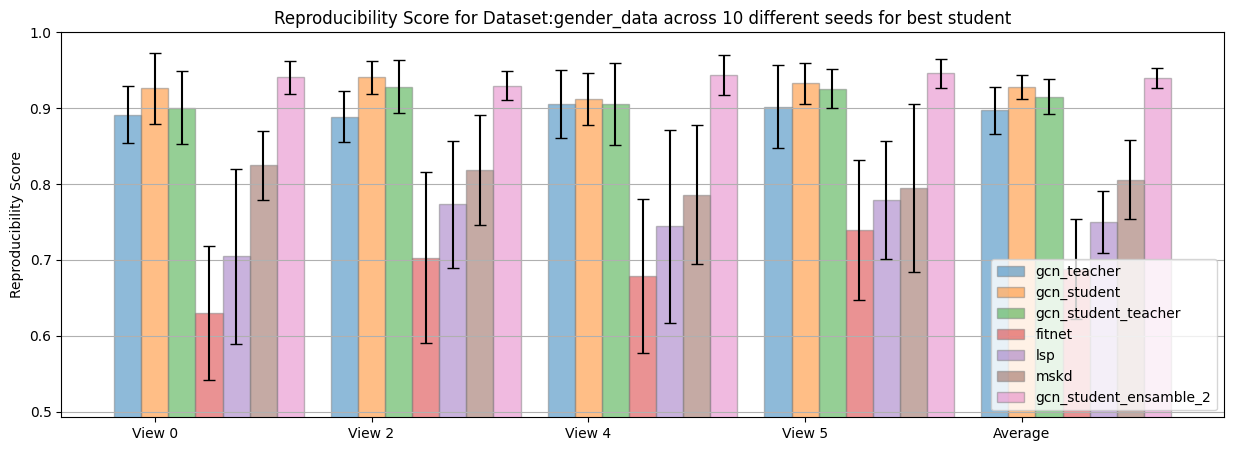

<Figure size 1500x500 with 0 Axes>

In [75]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_ensamble_2", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[0,0,1,1], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_2_args,
    ], 
    save_fig=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 0 Metric: acc


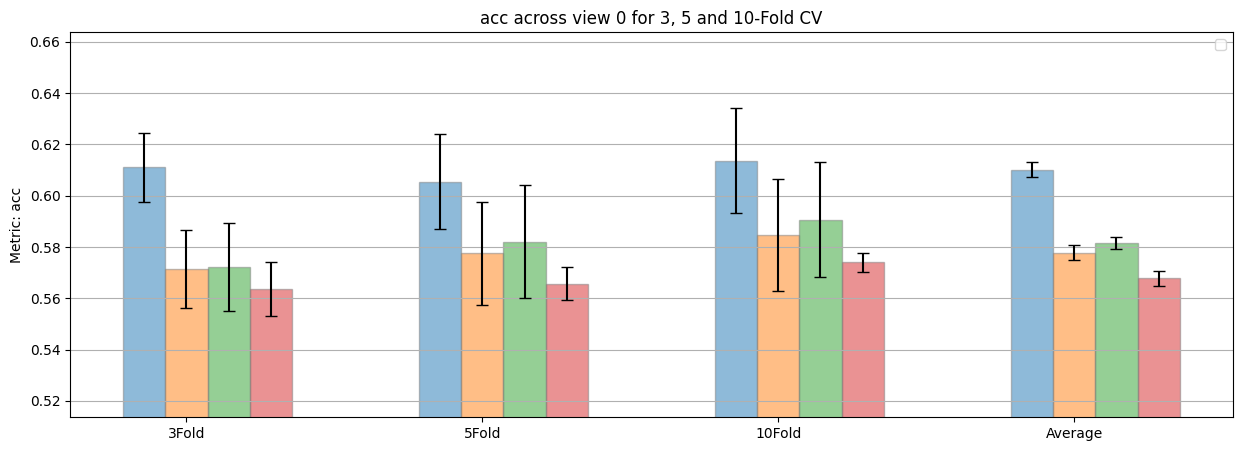

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 2 Metric: acc


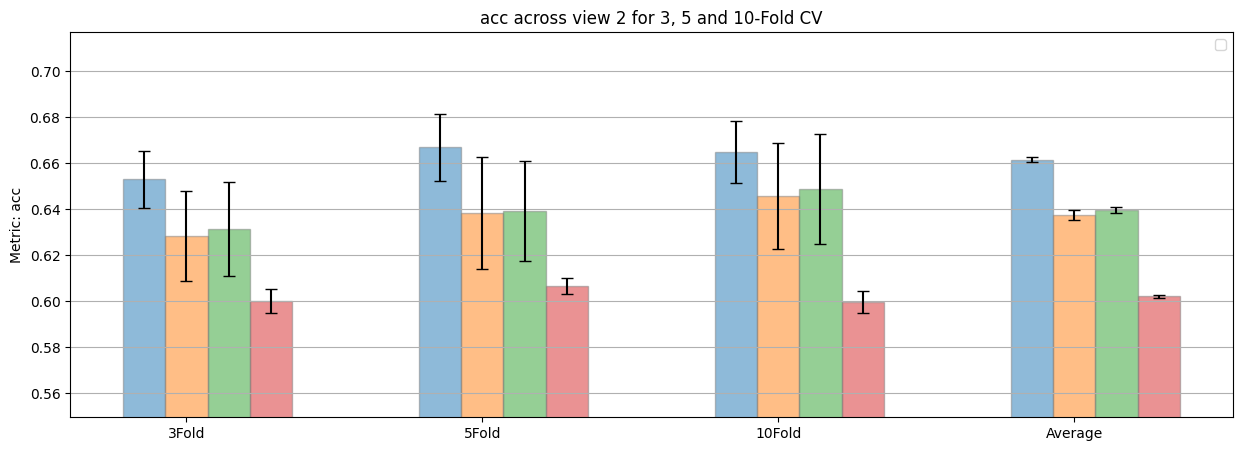

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 4 Metric: acc


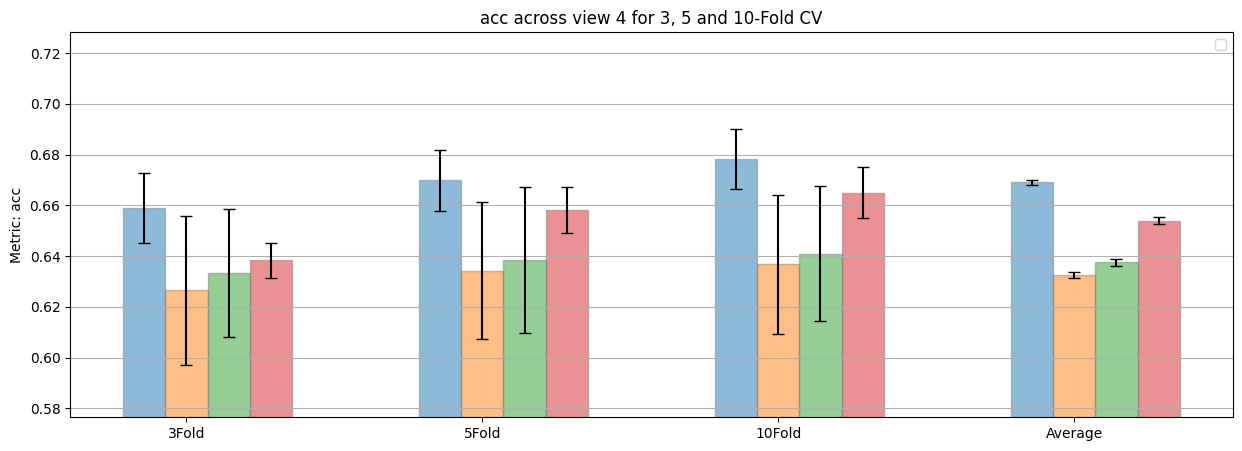

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 5 Metric: acc


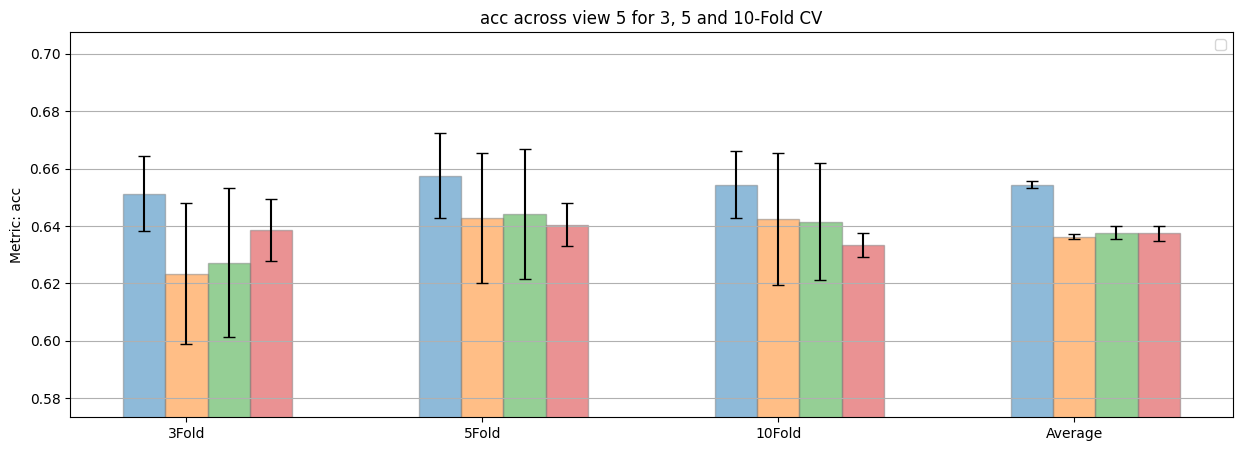

<Figure size 1500x500 with 0 Axes>

In [106]:
from models.model_config import *
views=[0, 2, 4, 5]
#models=["gcn", "gcn_student", "gcn_student_teacher"]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_ensamble_2"
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= gcn_student_ensamble_2_args
best_student = [0,0,1,1]

for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, 
                                                 CV=CV, view=view, 
                                                 run=run, 
                                                 metric="acc", 
                                                 dataset=dataset, 
                                                 dataset_split=dataset_split, 
                                                 analysis_type=analysis_type,
                                                 model_args=[gcn_args, gcn_student_args, gcn_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    mean = mean[index_student]
    std = std[index_student]
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = np.array(mean)[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(std)[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        barWidth = 1/7
        
        #GET MEAN AND STD ACROSS MEAN OF RUNS

        mean_all_runs = np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)]     
        mean_all_std = np.c_[ final_var_df, np.std(final_var_df, axis=1)]  
        
        X = np.arange(len(CV)+1)
        sep = 0.00
        for j, view_d in enumerate(mean_all_runs):
            plt.bar(X + sep, view_d, yerr=mean_all_std[j], capsize=4, width = barWidth, edgecolor ='grey', alpha=0.5)
            sep += barWidth
        
        max_y_lim = np.amax(mean_all_runs) + 0.05
        min_y_lim = np.amin(mean_all_runs) - 0.05
        plt.ylim(min_y_lim, max_y_lim)
        
        #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
        title = f"{metric} across view {view} for 3, 5 and 10-Fold CV"
        
        plt.ylabel(f"Metric: {metric}")
        x_ticks = [i for i in CV]+ ["Average"]
        
        plt.xticks([r + barWidth for r in range(len(CV)+1)], x_ticks)
        plt.title(title)
        plt.grid(axis = 'y')
        plt.legend()
        plt.show()
        plt.clf()   

# ANALYSIS 4 ENSAMBLE

In [131]:
analysis_type="model_assessment"
dataset_split="val"

for view in [0,2,4,5]:
    print(get_best_student_ensamble(
        model="gcn_student_ensamble_4", 
        view=view, 
        CV=CV,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=gcn_student_ensamble_4_args
    )
)

([0.9722222222222223, 0.00029629629629629727, 2], [0.9722222222222223, 0.00029629629629629727, 2], [0.9722222222222223, 0.00029629629629629727, 2])
([0.9530555555555557, 0.0005111111111111117, 1], [0.9530555555555557, 0.0005111111111111117, 1], [0.9530555555555557, 0.0005111111111111117, 1])
([0.961111111111111, 0.00013888888888888835, 2], [0.961111111111111, 0.00013888888888888835, 2], [0.961111111111111, 0.00013888888888888835, 2])
([0.9552777777777777, 0.0001380401234567913, 1], [0.9552777777777777, 0.0001380401234567913, 1], [0.9552777777777777, 0.0001380401234567913, 1])


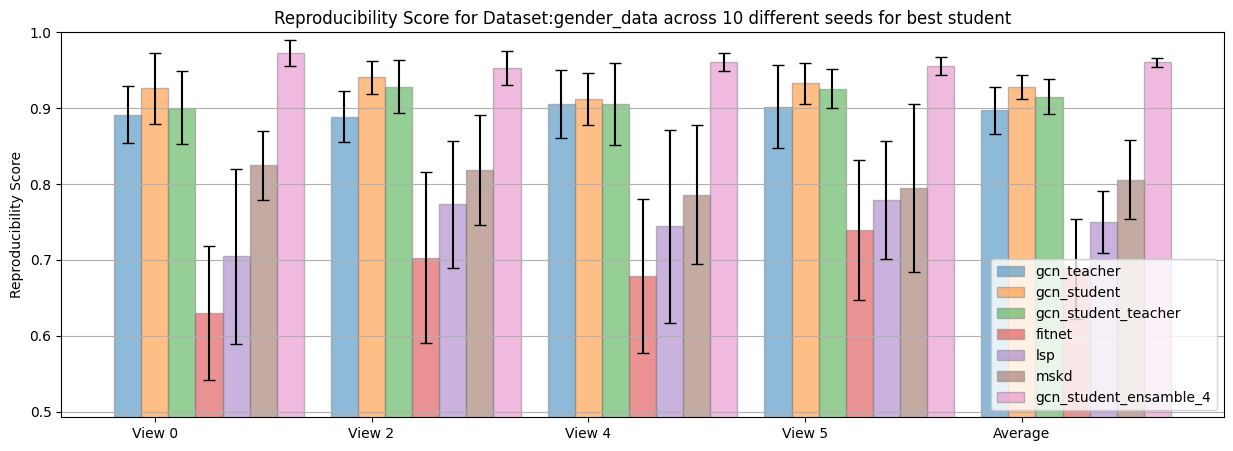

<Figure size 1500x500 with 0 Axes>

In [132]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_ensamble_4", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,1,2,1], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_4_args,
    ], 
    save_fig=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 0 Metric: acc


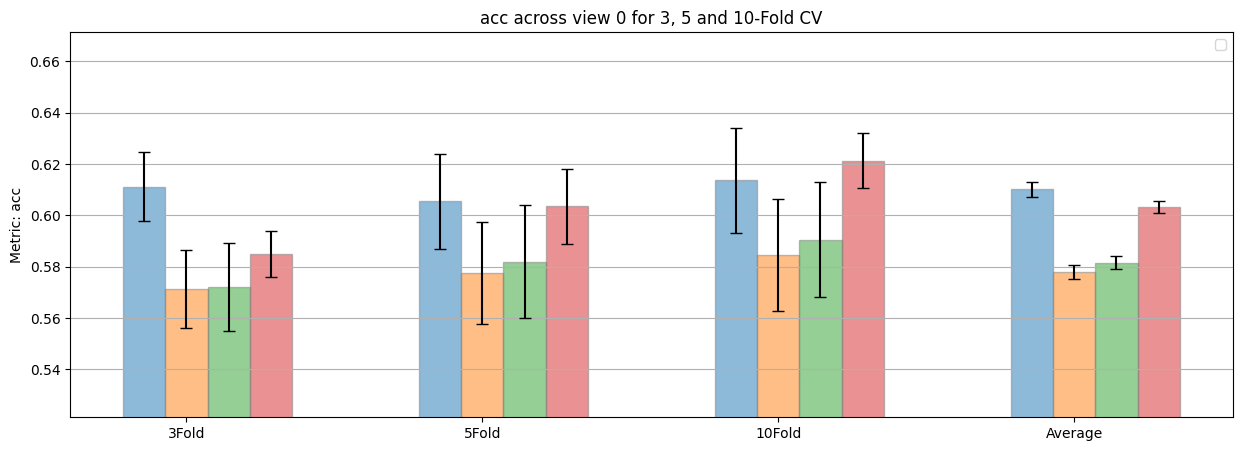

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 2 Metric: acc


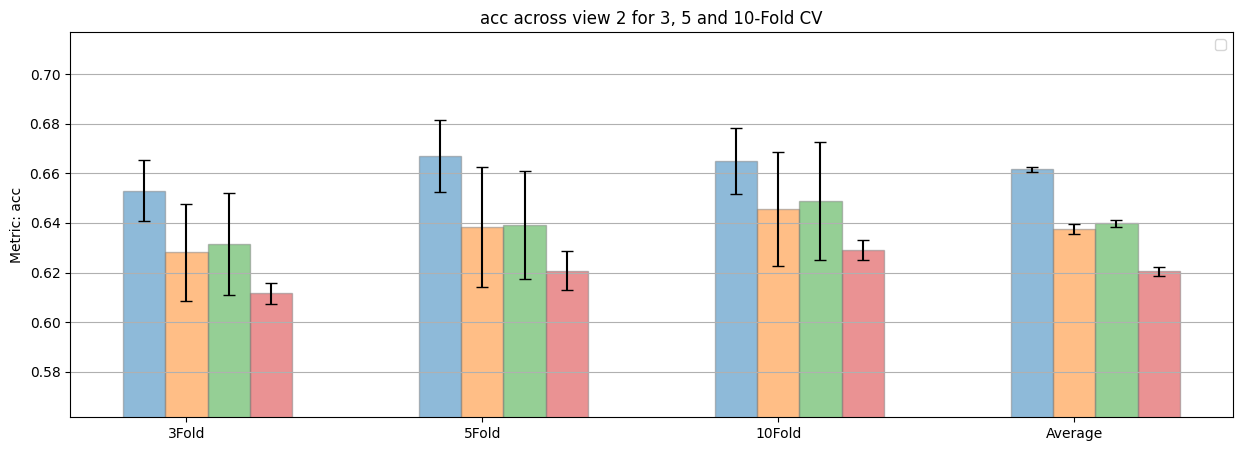

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 4 Metric: acc


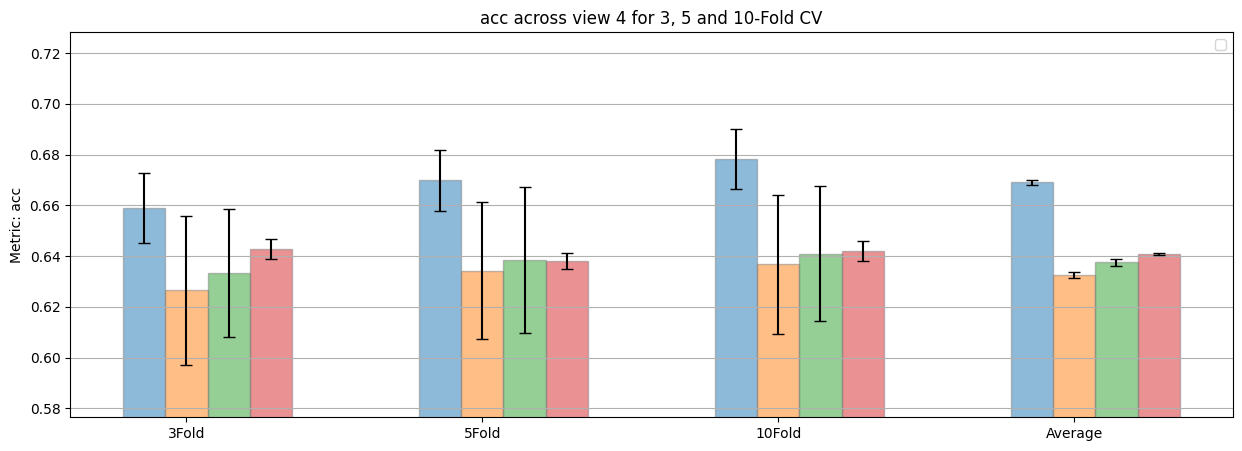

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 5 Metric: acc


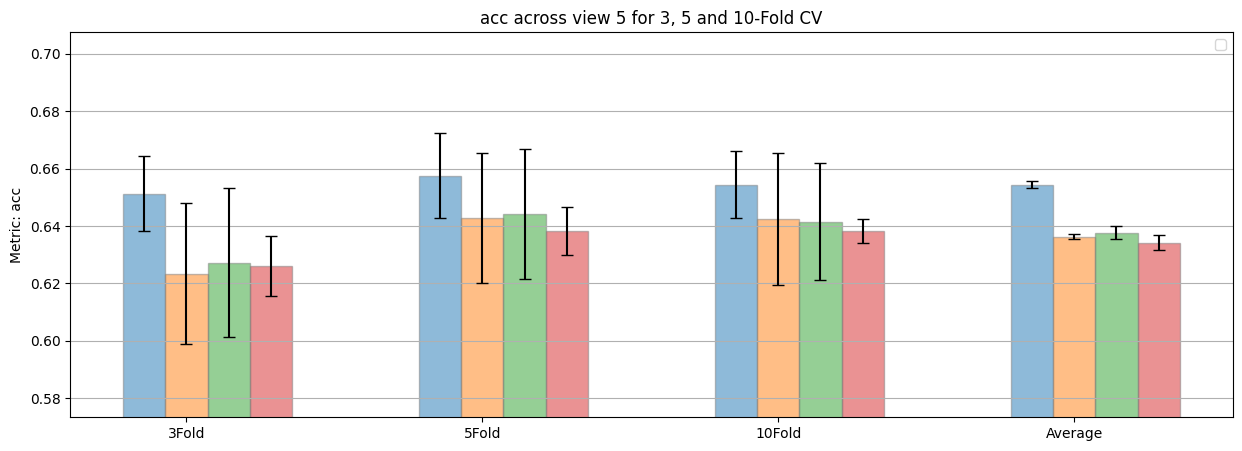

<Figure size 1500x500 with 0 Axes>

In [133]:
from models.model_config import *

views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_ensamble_4"
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= gcn_student_ensamble_4_args
best_student = [2,1,2,1]

for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, 
                                                 CV=CV, view=view, 
                                                 run=run, 
                                                 metric="acc", 
                                                 dataset=dataset, 
                                                 dataset_split=dataset_split, 
                                                 analysis_type=analysis_type,
                                                 model_args=[gcn_args, gcn_student_args, gcn_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    mean = mean[index_student]
    std = std[index_student]
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = np.array(mean)[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(std)[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        barWidth = 1/7
        
        #GET MEAN AND STD ACROSS MEAN OF RUNS

        mean_all_runs = np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)]     
        mean_all_std = np.c_[ final_var_df, np.std(final_var_df, axis=1)]  
        
        X = np.arange(len(CV)+1)
        sep = 0.00
        for j, view_d in enumerate(mean_all_runs):
            plt.bar(X + sep, view_d, yerr=mean_all_std[j], capsize=4, width = barWidth, edgecolor ='grey', alpha=0.5)
            sep += barWidth
        
        max_y_lim = np.amax(mean_all_runs) + 0.05
        min_y_lim = np.amin(mean_all_runs) - 0.05
        plt.ylim(min_y_lim, max_y_lim)
        
        #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
        title = f"{metric} across view {view} for 3, 5 and 10-Fold CV"
        
        plt.ylabel(f"Metric: {metric}")
        x_ticks = [i for i in CV]+ ["Average"]
        
        plt.xticks([r + barWidth for r in range(len(CV)+1)], x_ticks)
        plt.title(title)
        plt.grid(axis = 'y')
        plt.legend()
        plt.show()
        plt.clf()   

# ANALYSIS 5 ENSAMBLE

In [105]:
analysis_type="model_assessment"
dataset_split="val"

for view in [0,2,4,5]:
    print(get_best_student_ensamble(
        model="gcn_student_ensamble_5", 
        view=view, 
        CV=CV,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=gcn_student_ensamble_5_args
    )
)

([0.9668055555555555, 0.0004932291666666668, 1], [0.9652777777777779, 0.0005883487654321007, 2], [0.8848611111111111, 0.00023937114197530914, 4])
([0.9677777777777777, 0.00029660493827160506, 2], [0.9416666666666668, 0.0002472993827160485, 3], [0.9120833333333331, 0.0009656828703703679, 4])
([0.9755555555555555, 0.00021111111111111076, 2], [0.9755555555555555, 0.00021111111111111076, 2], [0.9755555555555555, 0.00021111111111111076, 2])
([0.9597222222222221, 0.0005636574074074058, 2], [0.9377777777777776, 0.00037415123456790094, 3], [0.9377777777777776, 0.00037415123456790094, 3])


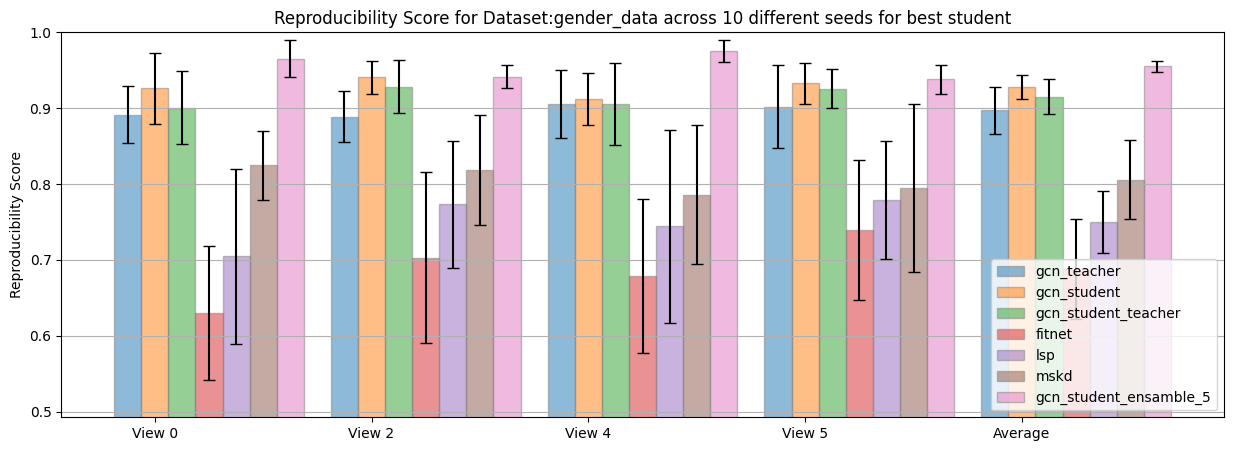

<Figure size 1500x500 with 0 Axes>

In [107]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_ensamble_5", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,3,2,3], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_5_args,
    ], 
    save_fig=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 0 Metric: acc


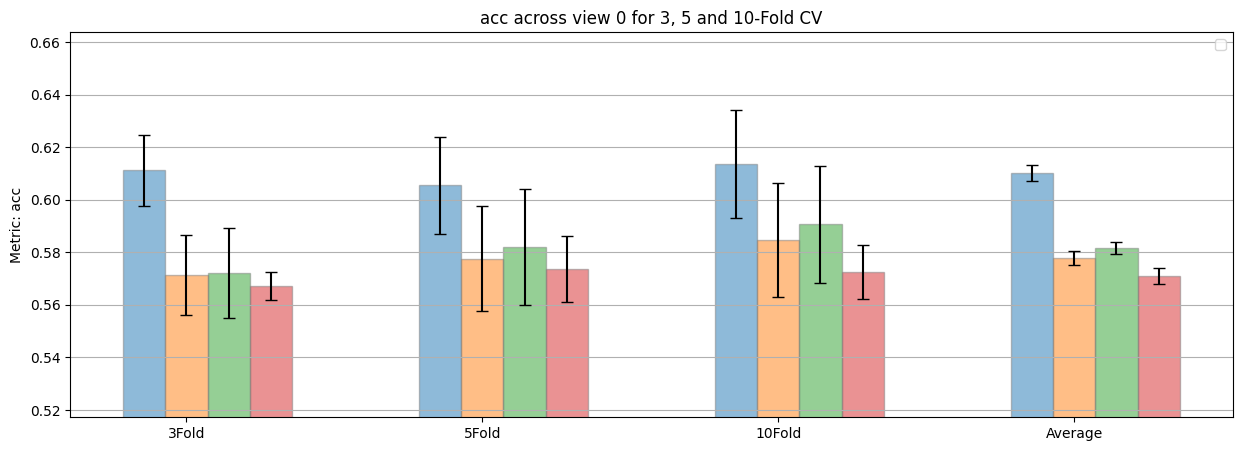

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 2 Metric: acc


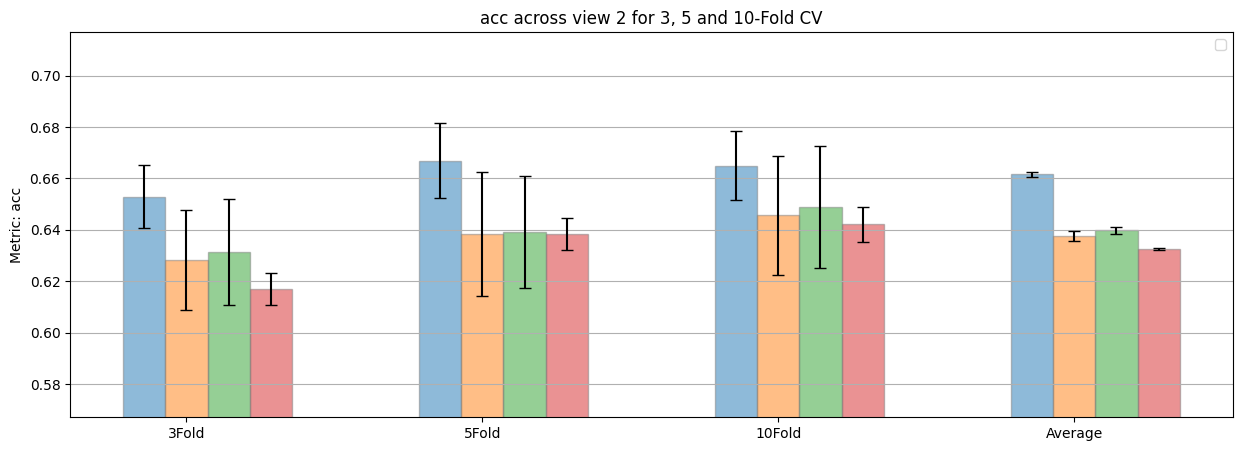

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 4 Metric: acc


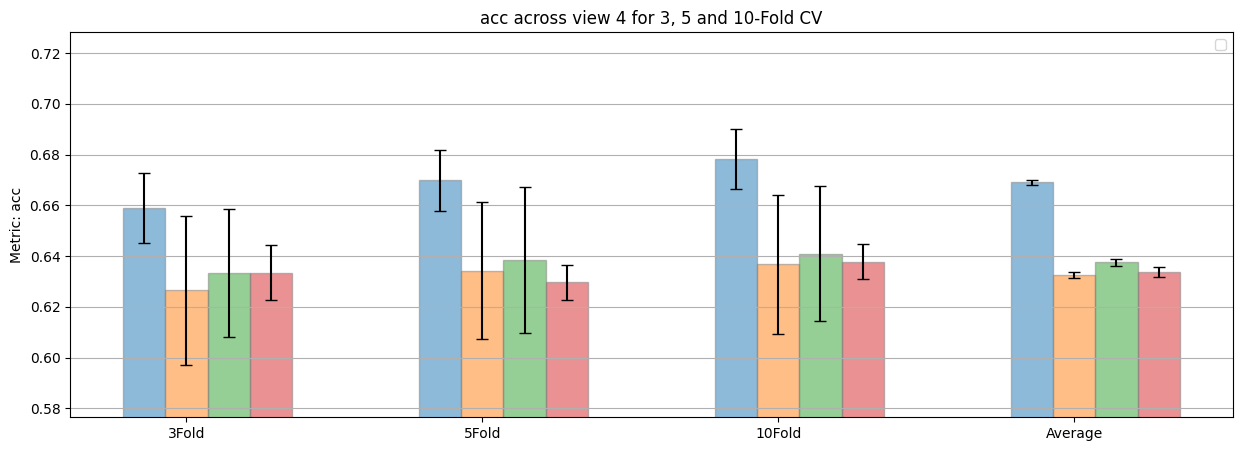

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 5 Metric: acc


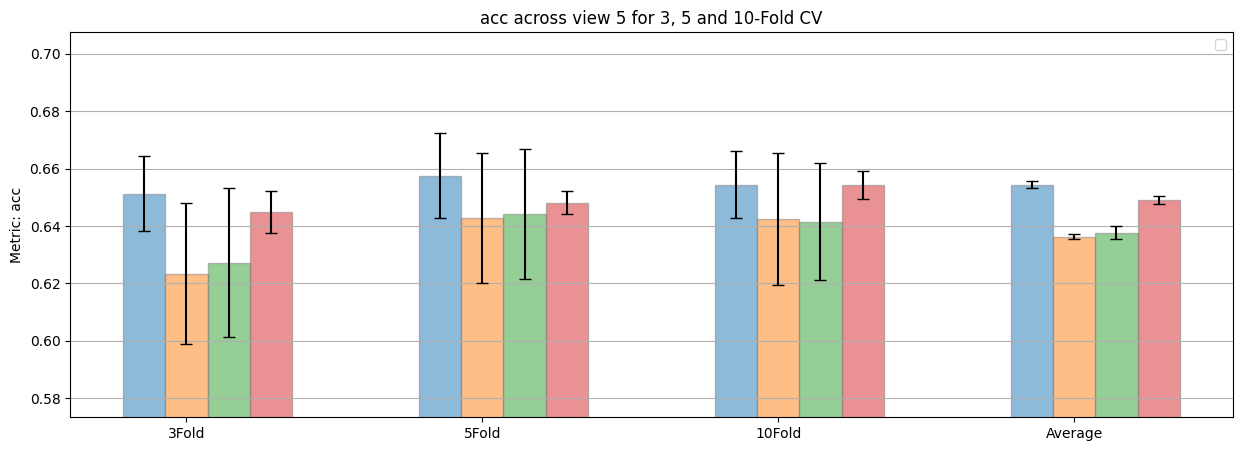

<Figure size 1500x500 with 0 Axes>

In [108]:
from models.model_config import *

views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_ensamble_5"
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= gcn_student_ensamble_5_args
best_student = [2,3,2,3]

for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, 
                                                 CV=CV, view=view, 
                                                 run=run, 
                                                 metric="acc", 
                                                 dataset=dataset, 
                                                 dataset_split=dataset_split, 
                                                 analysis_type=analysis_type,
                                                 model_args=[gcn_args, gcn_student_args, gcn_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    mean = mean[index_student]
    std = std[index_student]
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = np.array(mean)[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(std)[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        barWidth = 1/7
        
        #GET MEAN AND STD ACROSS MEAN OF RUNS

        mean_all_runs = np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)]     
        mean_all_std = np.c_[ final_var_df, np.std(final_var_df, axis=1)]  
        
        X = np.arange(len(CV)+1)
        sep = 0.00
        for j, view_d in enumerate(mean_all_runs):
            plt.bar(X + sep, view_d, yerr=mean_all_std[j], capsize=4, width = barWidth, edgecolor ='grey', alpha=0.5)
            sep += barWidth
        
        max_y_lim = np.amax(mean_all_runs) + 0.05
        min_y_lim = np.amin(mean_all_runs) - 0.05
        plt.ylim(min_y_lim, max_y_lim)
        
        #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
        title = f"{metric} across view {view} for 3, 5 and 10-Fold CV"
        
        plt.ylabel(f"Metric: {metric}")
        x_ticks = [i for i in CV]+ ["Average"]
        
        plt.xticks([r + barWidth for r in range(len(CV)+1)], x_ticks)
        plt.title(title)
        plt.grid(axis = 'y')
        plt.legend()
        plt.show()
        plt.clf()   

# ENSEMBLE ANLAYISIS

In [134]:
# get the best reproducibility across all runs 
student_rep = []

for run in [i for i in range(10)]:

    view_rep, _ = view_reproducibility_analysis(
        dataset=dataset, 
        models=[
            "gcn_student_ensamble_2",
            "gcn_student_ensamble_3",
            "gcn_student_ensamble_4",
            "gcn_student_ensamble_5"
            ], 
        CV=CV, 
        views=[0,2,4,5], 
        run=run, 
        students=[-1,-1,-1,-1], 
        model_args=[
            gcn_student_ensamble_2_args,
            gcn_student_ensamble_3_args,
            gcn_student_ensamble_4_args,
            gcn_student_ensamble_5_args
            ]
    )
    #store the reproducibility score for all students for the run 
    student_rep.append(view_rep)

#get the mean and variance for the reproducibility scores for all the students
student_var = np.var(student_rep, axis=0)
student_rep = np.mean(student_rep, axis=0)
student_rep, student_var

(array([[0.86652778, 0.91680556, 0.92291667, 0.91055556, 0.90420139],
        [0.93694444, 0.88541667, 0.89527778, 0.95388889, 0.91788194],
        [0.95166667, 0.88791667, 0.91263889, 0.95      , 0.92555556],
        [0.88138889, 0.90555556, 0.9125    , 0.90736111, 0.90170139]]),
 array([[2.51716821e-04, 1.00868056e-04, 4.12519290e-04, 2.48148148e-04,
         8.25966917e-05],
        [8.61188272e-04, 1.09153164e-03, 4.78472222e-04, 2.56095679e-04,
         2.64015480e-04],
        [5.25000000e-04, 4.22087191e-04, 5.87750772e-04, 2.32638889e-04,
         1.89554398e-04],
        [3.34567901e-04, 4.01620370e-04, 4.74537037e-04, 9.00096451e-04,
         1.41407456e-04]]))

In [137]:
from models.model_config import *
views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]

mean_gcn_student, std_gcn_student = get_model_metric(dataset=dataset,
                                                     model="gcn_student_ensamble_4", 
                                                     CV=CV, 
                                                     runs=[i for i in range(10)], 
                                                     analysis_type=analysis_type, 
                                                     dataset_split=dataset_split, 
                                                     view=2, 
                                                     model_args=gcn_student_ensamble_4_args)


In [138]:
mean_gcn_student

[array([[0.64741871, 0.50619872, 0.41888127, 0.66023804],
        [0.66506536, 0.56691766, 0.51090294, 0.65676834],
        [0.65962356, 0.53595985, 0.45468468, 0.66832623]])]

In [ ]:
# Reproducibility vs params 
# Reproduciility vs accuracy